# **DeepBedMap**

Predicting the bed elevation of Antarctica using our trained Super Resolution Deep Neural Network.
The results will be compared against other interpolated grid products along groundtruth tracks in small regions.
Finally we will produce an Antarctic-wide DeepBedMap Digital Elevation Model (DEM) at the very end!

In [1]:
import math
import os
import typing

os.environ["CUDA_VISIBLE_DEVICES"] = ""

import xarray as xr
import salem

import comet_ml
import cupy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import pandas as pd
import pygmt as gmt
import quilt
import rasterio
import skimage

import chainer

from features.environment import _load_ipynb_modules, _download_model_weights_from_comet

data_prep = _load_ipynb_modules("data_prep.ipynb")

# 1. Gather datasets

## 1.1 Get bounding box of our area of interest

Basically predict on an place where we have groundtruth data to validate against.

In [2]:
def get_image_with_bounds(filepaths: list, indexers: dict = None) -> xr.DataArray:
    """
    Retrieve raster image in xarray.DataArray format patched
    with projected coordinate bounds as (xmin, ymin, xmax, ymax)

    Note that if more than one filepath is passed in,
    the output groundtruth image array will not be valid
    (see https://github.com/pydata/xarray/issues/2159),
    but the window_bound extents will be correct
    """

    with xr.open_mfdataset(
        paths=filepaths, combine="nested", concat_dim=None
    ) as dataset:
        # Retrieve dataarray from NetCDF datasets
        dataarray = dataset.z.isel(indexers=indexers)

    # Patch projection information into xarray grid
    dataarray.attrs["pyproj_srs"] = "epsg:3031"
    sgrid = dataarray.salem.grid.corner_grid
    assert sgrid.origin == "lower-left"  # should be "lower-left", not "upper-left"

    # Patch bounding box extent into xarray grid
    if len(filepaths) == 1:
        left, right, bottom, top = sgrid.extent
    elif len(filepaths) > 1:
        print("WARN: using multiple inputs, output groundtruth image may look funny")
        x_offset, y_offset = sgrid.dx / 2, sgrid.dy / 2
        left, right = (
            float(dataarray.x[0] - x_offset),
            float(dataarray.x[-1] + x_offset),
        )
        assert sgrid.x0 == left
        bottom, top = (
            float(dataarray.y[0] - y_offset),
            float(dataarray.y[-1] + y_offset),
        )
        assert sgrid.y0 == bottom  # dataarray.y.min()-y_offset

    # check that y-axis and x-axis lengths are divisible by 4
    try:
        shape = int((top - bottom) / sgrid.dy), int((right - left) / sgrid.dx)
        assert all(i % 4 == 0 for i in shape)
    except AssertionError:
        print(f"WARN: Image shape {shape} should be divisible by 4 for DeepBedMap")
    finally:
        dataarray.attrs["bounds"] = [left, bottom, right, top]

    return dataarray

In [3]:
test_filepaths = ["highres/2007tx"]  # , "highres/2010tr", "highres/istarxx"]
groundtruth = get_image_with_bounds(
    filepaths=[f"{t}.nc" for t in test_filepaths],
    indexers=None,  # for 2007tx
    # indexers={"y": slice(0, -1)},  # for 2007tx, 2010tr and istarxx
)

## 1.2 Get neural network input datasets

Collect BEDMAP2 (X), REMA (W1), MEaSUREs Ice Flow (W2) and Antarctic Snow Accumulation (W3) datasets
cropped to our area of interest that will be fed into our trained neural network later.

In [4]:
def get_deepbedmap_model_inputs(
    window_bound: rasterio.coords.BoundingBox, padding=0
) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    """
    Outputs one large tile for each of:
    BEDMAP2, REMA, MEASURES Ice Flow Velocity and Antarctic Snow Accumulation
    according to a given window_bound in the form of (xmin, ymin, xmax, ymax).
    """
    data_prep = _load_ipynb_modules("data_prep.ipynb")

    X_tile = data_prep.selective_tile(
        filepath="lowres/bedmap2_bed.tif",
        window_bounds=[[*window_bound]],
        # out_shape=None,  # 1000m spatial resolution
        padding=padding,
        gapfiller=-5000.0,
    )
    W3_tile = data_prep.selective_tile(
        filepath="misc/Arthern_accumulation_bedmap2_grid1.tif",
        window_bounds=[[*window_bound]],
        # out_shape=None,  # 1000m spatial resolution
        padding=padding,
        gapfiller=0.0,
    )
    W2_tile = np.concatenate(
        [
            data_prep.selective_tile(
                filepath="netcdf:misc/antarctic_ice_vel_phase_map_v01.nc:VX",
                window_bounds=[[*window_bound]],
                # out_shape=None,  # 450m spatial resolution
                padding=padding,
            ),
            data_prep.selective_tile(
                filepath="netcdf:misc/antarctic_ice_vel_phase_map_v01.nc:VY",
                window_bounds=[[*window_bound]],
                # out_shape=None,  # 450m spatial resolution
                padding=padding,
            ),
        ],
        axis=1,
    )
    W1_tile = data_prep.selective_tile(
        filepath="misc/REMA_100m_dem_filled.tif",
        window_bounds=[[*window_bound]],
        # out_shape=(X_tile.shape[2] * 10, X_tile.shape[3] * 10),  # 100m spatial resolution
        padding=padding,
    )

    return X_tile, W1_tile, W2_tile, W3_tile

In [5]:
window_bound = groundtruth.bounds
X_tile, W1_tile, W2_tile, W3_tile = get_deepbedmap_model_inputs(
    window_bound=window_bound
)
print(X_tile.shape, W1_tile.shape, W2_tile.shape, W3_tile.shape)

# Build quilt package for datasets covering our test region
reupload = False
if reupload == True:
    quilt.build(package="weiji14/deepbedmap/model/test/W1_tile", path=W1_tile)
    quilt.build(package="weiji14/deepbedmap/model/test/W2_tile", path=W2_tile)
    quilt.build(package="weiji14/deepbedmap/model/test/W3_tile", path=W3_tile)
    quilt.build(package="weiji14/deepbedmap/model/test/X_tile", path=X_tile)
    quilt.push(package="weiji14/deepbedmap/model/test", is_public=True)

Tiling: lowres/bedmap2_bed.tif ... done!
Tiling: misc/Arthern_accumulation_bedmap2_grid1.tif ... done!
Tiling: netcdf:misc/antarctic_ice_vel_phase_map_v01.nc:VX ... done!
Tiling: netcdf:misc/antarctic_ice_vel_phase_map_v01.nc:VY ... done!
Tiling: misc/REMA_200m_dem_filled.tif ... done!
(1, 1, 72, 20) (1, 1, 720, 200) (1, 2, 160, 44) (1, 1, 72, 20)


In [6]:
def plot_3d_view(
    img: np.ndarray,
    ax: matplotlib.axes._subplots.Axes,
    elev: int = 60,
    azim: int = 330,
    z_minmax: tuple = None,
    title: str = None,
    zlabel: str = None,
):
    """
    Creates a 3D perspective view plot of an elevation surface using matplotlib 3D.
    The elevation (elev) and azimuth (azim) angle will need to be set accordingly,
    here it is looking from the SouthWest (330deg) at an angle 60deg above the z-plane.

    There are also optional parameters to set an elevation (z) range using the z_minmax
    parameter, just provide a tuple in the form of (zmin, zmax). The resulting 3D plot's
    colours will also be scaled to this range, or to the input array's z-range if this
    z_minmax setting is left blank. You can also provide a title and z-axis label.
    """
    # Get x, y, z data, assuming image in NCHW format
    image = img[0, :, :, :]
    xx, yy = np.mgrid[0 : image.shape[1], 0 : image.shape[2]]
    zz = image[0, :, :]

    # Scale the plot colours according to some elevation(z) range
    zmin, zmax = z_minmax if z_minmax is not None else (img.min(), img.max())
    cm_norm = matplotlib.cm.colors.Normalize(vmin=zmin, vmax=zmax)

    # Make the 3D surface plot
    ax.view_init(elev=elev, azim=azim)
    ax.plot_surface(xx, yy, zz, cmap="BrBG", norm=cm_norm)

    # Set title for plot and z-axis label
    ax.set_title(label=f"{title}\n", fontsize=22)
    ax.set_zlabel(zlabel=f"\n\n{zlabel}", fontsize=16)
    ax.set_zlim(bottom=zmin, top=zmax)

    return ax

### Plot figures of neural network raster inputs in 2D and 3D

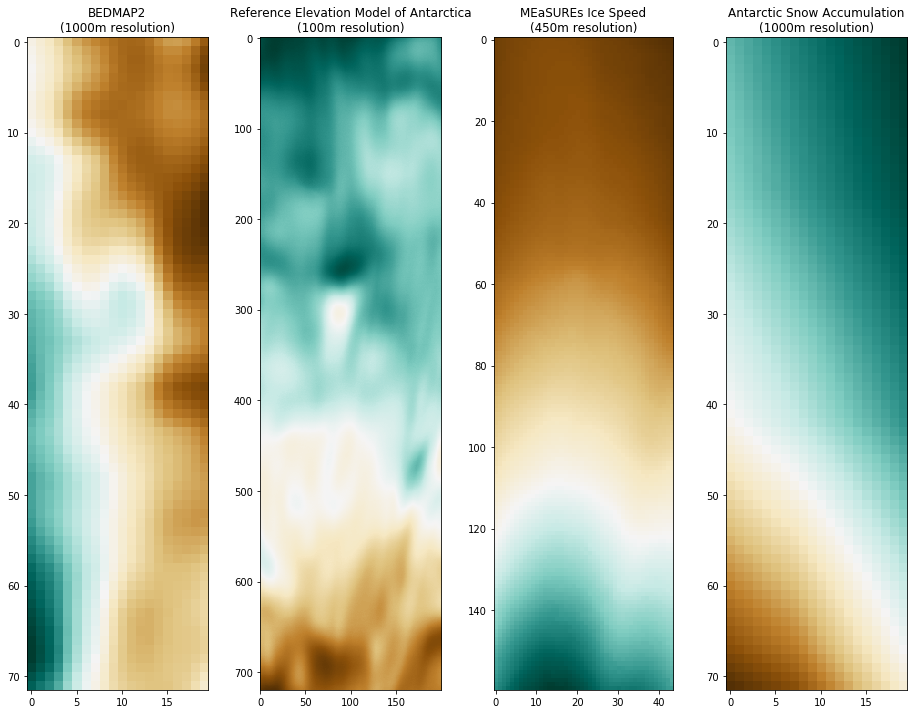

In [7]:
fig, axarr = plt.subplots(nrows=1, ncols=4, squeeze=False, figsize=(16, 12))
axarr[0, 0].imshow(X_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 0].set_title("BEDMAP2\n(1000m resolution)")
axarr[0, 1].imshow(W1_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 1].set_title("Reference Elevation Model of Antarctica\n(100m resolution)")
axarr[0, 2].imshow(np.linalg.norm(W2_tile, axis=(0, 1)), cmap="BrBG")
axarr[0, 2].set_title("MEaSUREs Ice Speed\n(450m resolution)")
axarr[0, 3].imshow(W3_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 3].set_title("Antarctic Snow Accumulation\n(1000m resolution)")
plt.show()

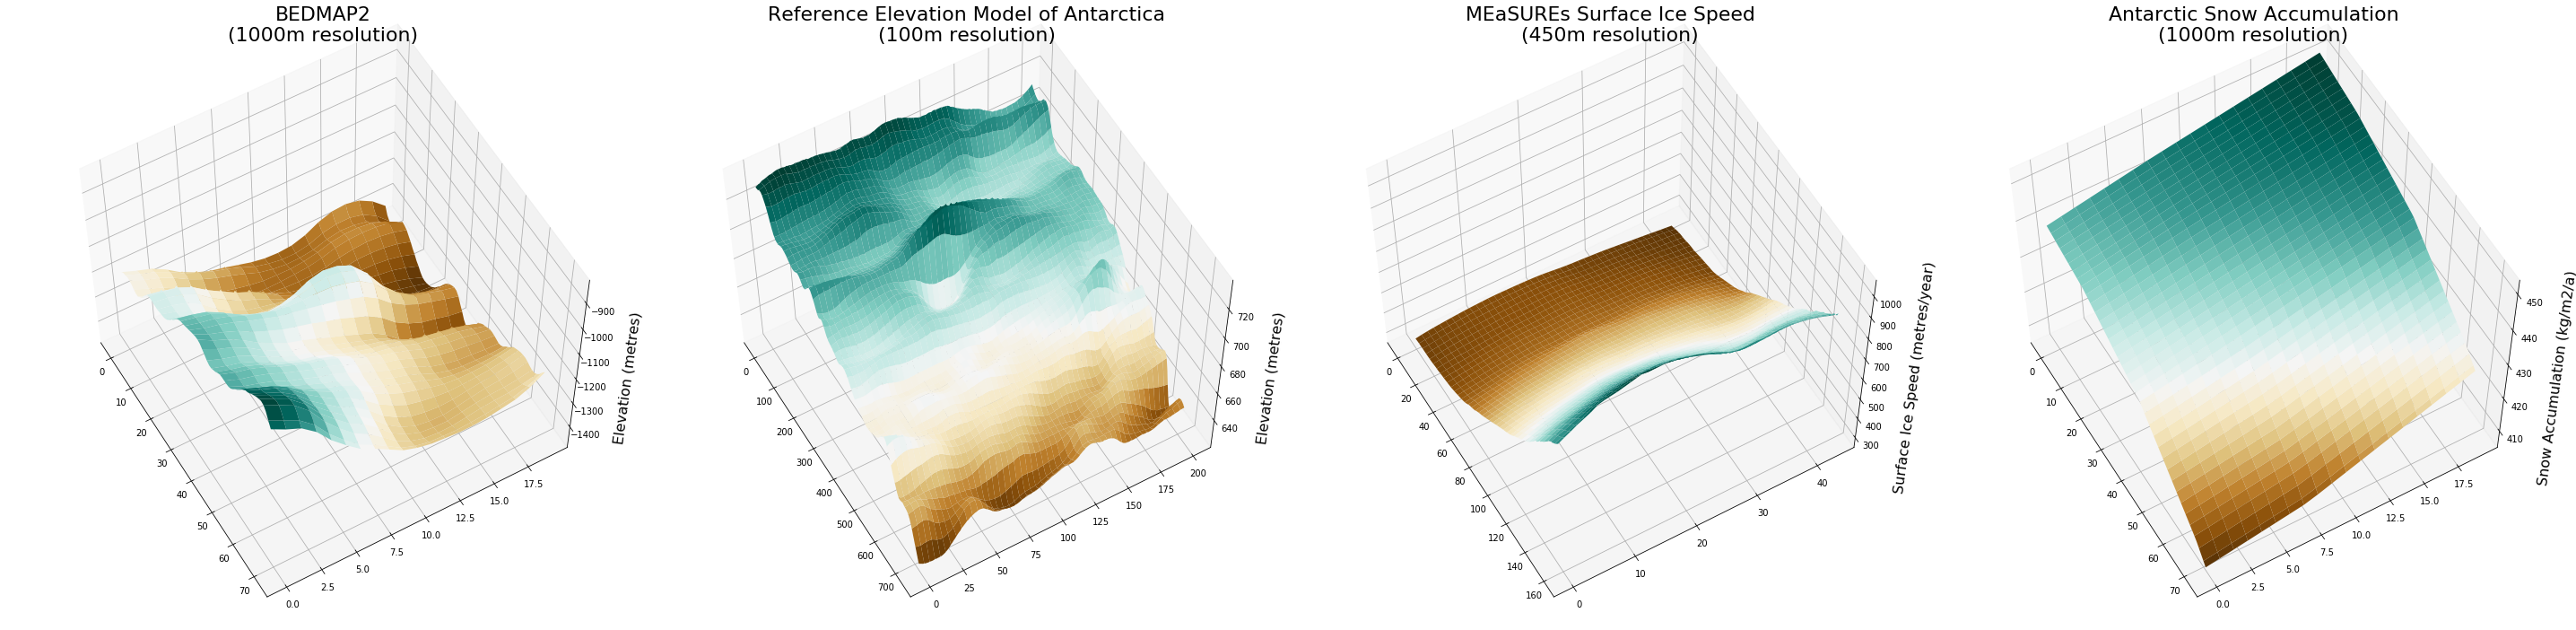

In [8]:
fig = plt.figure(figsize=plt.figaspect(1 / 4) * 2.5)
axarr = [fig.add_subplot(1, 4, i + 1, projection="3d") for i in range(4)]

plot_3d_view(
    img=X_tile,
    ax=axarr[0],
    title="BEDMAP2\n(1000m resolution)",
    zlabel="Elevation (metres)",
)
plot_3d_view(
    img=W1_tile,
    ax=axarr[1],
    title="Reference Elevation Model of Antarctica\n(100m resolution)",
    zlabel="Elevation (metres)",
)
plot_3d_view(
    img=np.expand_dims(np.linalg.norm(W2_tile, axis=1), axis=0),
    ax=axarr[2],
    title="MEaSUREs Surface Ice Speed\n(450m resolution)",
    zlabel="Surface Ice Speed (metres/year)",
)
plot_3d_view(
    img=W3_tile,
    ax=axarr[3],
    title="Antarctic Snow Accumulation\n(1000m resolution)",
    zlabel="Snow Accumulation (kg/m2/a)",
)

plt.tight_layout()
plt.show()

## 1.3 Prepare other interpolated grids for comparison

We'll also have two other grids (interpolated to spatial resolution of 250m) to compare with our DeepBedMap model's prediction.
They are:

- Bicubic interpolated BEDMAP2 (baseline)
- Synthetic High Resolution Grid from [Graham et al. 2017](https://doi.org/10.5194/essd-9-267-2017)

In [9]:
cubicbedmap2 = skimage.transform.rescale(
    image=X_tile[0, 0, :, :].astype(np.int32),
    scale=4,  # 4x upscaling
    order=3,  # cubic interpolation
    mode="reflect",
    anti_aliasing=True,
    multichannel=False,
    preserve_range=True,
)
cubicbedmap2 = np.expand_dims(np.expand_dims(cubicbedmap2, axis=0), axis=0)
print(cubicbedmap2.shape)

(1, 1, 288, 80)


In [10]:
S_tile = data_prep.selective_tile(
    filepath="model/hres.tif", window_bounds=[[*window_bound]]
)
print(S_tile.shape)
synthetic250 = skimage.transform.rescale(
    image=S_tile[0, 0, :, :].astype(np.int32),
    scale=1 / 2.5,  # 2.5 downscaling
    order=1,  # billinear interpolation
    mode="reflect",
    anti_aliasing=True,
    multichannel=False,
    preserve_range=True,
)
synthetic250 = np.expand_dims(np.expand_dims(synthetic250, axis=0), axis=0)
print(synthetic250.shape)

Tiling: model/hres.tif ... done!
(1, 1, 720, 200)
(1, 1, 288, 80)


# 2. Predict Bed Elevation

## 2.1 Load trained generator neural network

Fully convolutional networks rock!!
Since we have a fully convolutional model architecture,
we can use the same trained weights on different sized inputs/outputs!
That way we can predict directly on an arbitrarily sized window.

In [11]:
def load_trained_model(
    experiment_key: str = "13ce79f397214197a331488db41ebf7c",  # or simply use "latest"
    model_weights_path: str = "model/weights/srgan_generator_model_weights.npz",
):
    """
    Returns a trained Generator DeepBedMap neural network model.

    The model's weights and hyperparameters settings are retrieved from
    https://comet.ml/weiji14/deepbedmap using an `experiment_key` setting
    which can be set to 'latest' or some 32-character alphanumeric string.
    """
    srgan_train = _load_ipynb_modules("srgan_train.ipynb")

    # Download either 'latest' model weights from Comet.ML or one using experiment_key
    # Will also get the hyperparameters "num_residual_blocks" and "residual_scaling"
    num_residual_blocks, residual_scaling = _download_model_weights_from_comet(
        experiment_key=experiment_key, download_path=model_weights_path
    )

    # Architect the model with appropriate "num_residual_blocks" and "residual_scaling"
    model = srgan_train.GeneratorModel(
        num_residual_blocks=num_residual_blocks, residual_scaling=residual_scaling
    )

    # Load trained neural network weights into model
    chainer.serializers.load_npz(file=model_weights_path, obj=model)

    return model

In [12]:
model = load_trained_model()

## 2.2 Make prediction on area of interest

In [13]:
Y_hat = model.forward(x=X_tile, w1=W1_tile, w2=W2_tile, w3=W3_tile).array

### Plot DeepBedMap prediction alongside other interpolated grids and groundtruth in 2D and 3D

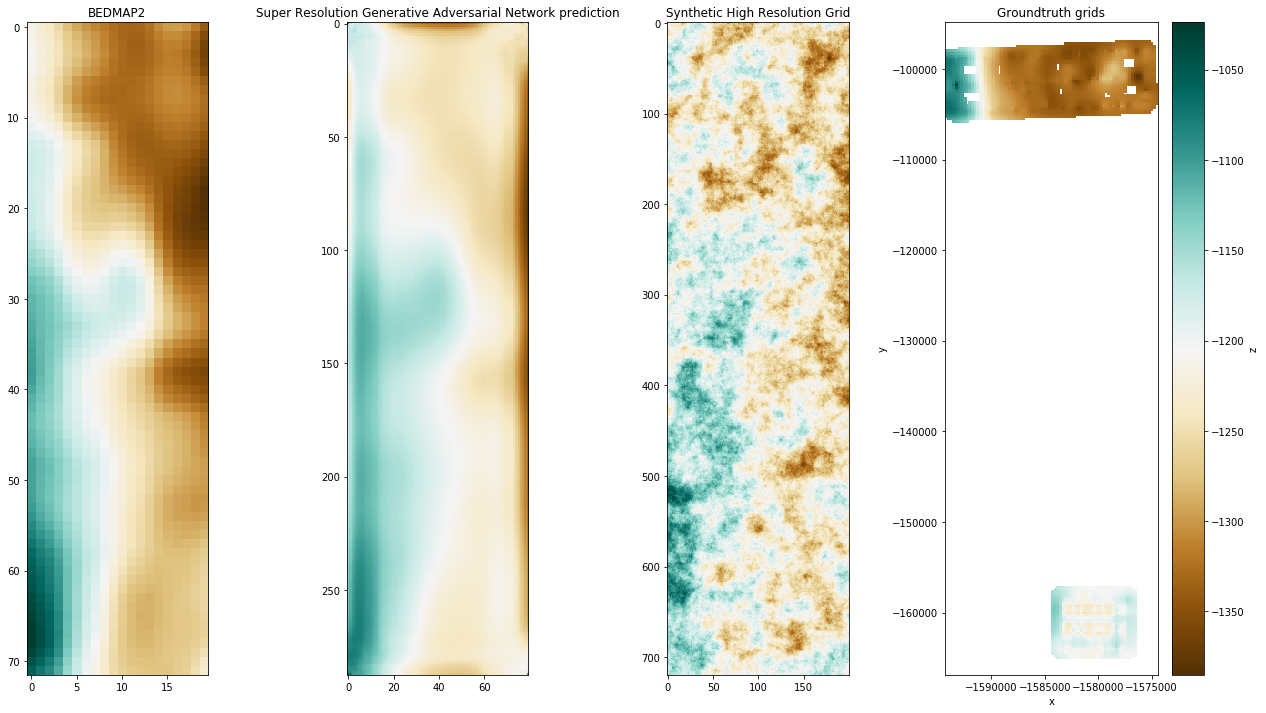

In [14]:
fig, axarr = plt.subplots(nrows=1, ncols=4, squeeze=False, figsize=(22, 12))
axarr[0, 0].imshow(X_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 0].set_title("BEDMAP2")
axarr[0, 1].imshow(Y_hat[0, 0, :, :], cmap="BrBG")
axarr[0, 1].set_title("Super Resolution Generative Adversarial Network prediction")
axarr[0, 2].imshow(S_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 2].set_title("Synthetic High Resolution Grid")
groundtruth.plot(ax=axarr[0, 3], cmap="BrBG")
axarr[0, 3].set_title("Groundtruth grids")
plt.show()

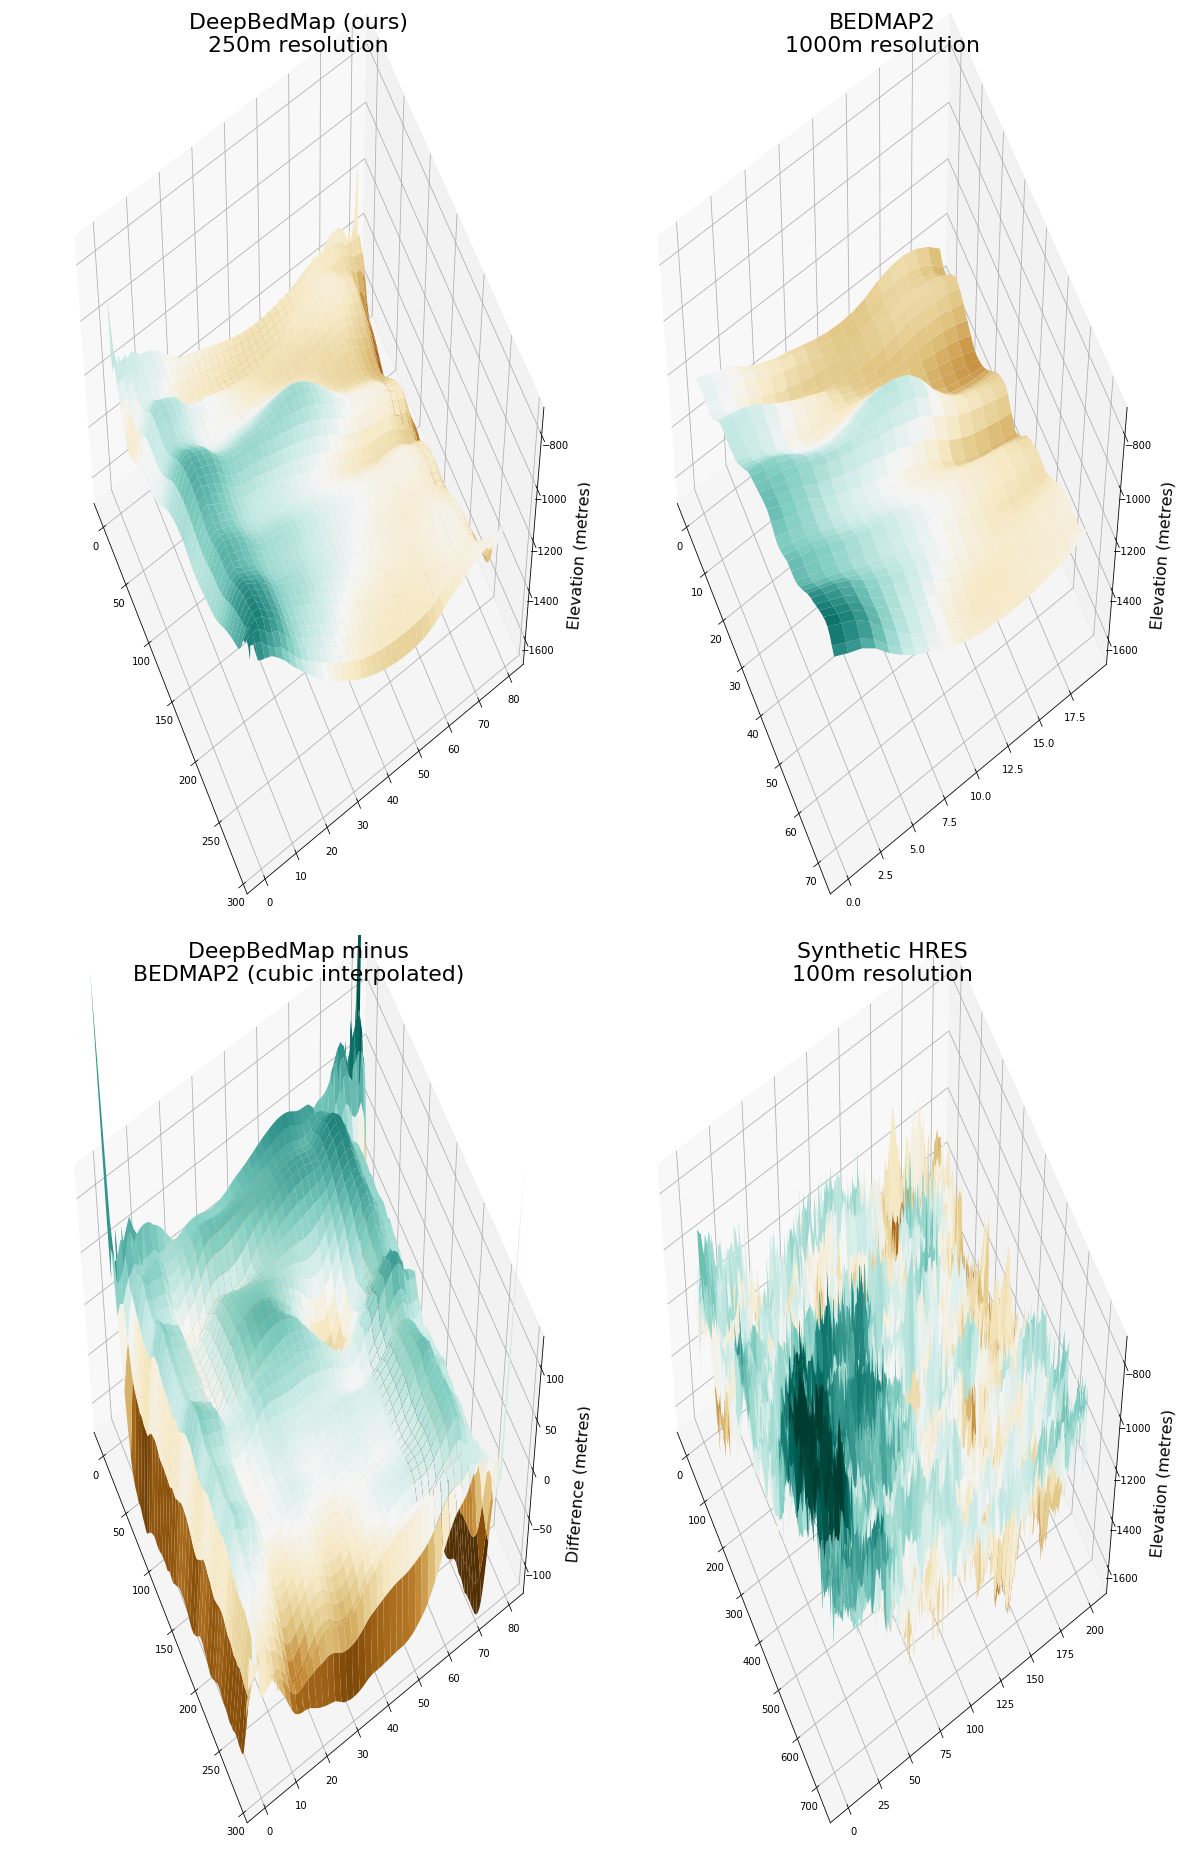

In [15]:
fig = plt.figure(figsize=plt.figaspect(12 / 9) * 4.5)  # (height/width)*scaling
axarr = [fig.add_subplot(2, 2, i + 1, projection="3d") for i in range(4)]

plot_3d_view(
    img=Y_hat,  # DeepBedMap
    ax=axarr[0],
    z_minmax=(Y_hat.min(), Y_hat.max()),
    title="DeepBedMap (ours)\n250m resolution",
    zlabel="Elevation (metres)",
)
plot_3d_view(
    img=X_tile,  # BEDMAP2
    ax=axarr[1],
    z_minmax=(Y_hat.min(), Y_hat.max()),
    title="BEDMAP2\n1000m resolution",
    zlabel="Elevation (metres)",
)
plot_3d_view(
    img=Y_hat - cubicbedmap2,  # DeepBedMap - BEDMAP2
    ax=axarr[2],
    z_minmax=(-125, 125),
    title="DeepBedMap minus\nBEDMAP2 (cubic interpolated)",
    zlabel="Difference (metres)",
)
plot_3d_view(
    img=S_tile,  # Synthetic High Resolution product
    ax=axarr[3],
    z_minmax=(Y_hat.min(), Y_hat.max()),
    title="Synthetic HRES\n100m resolution",
    zlabel="Elevation (metres)",
)

plt.subplots_adjust(wspace=0.0001, hspace=0.0001, left=0.0, right=0.9, top=1.2)
# plt.savefig(fname="esrgan_prediction.pdf", format="pdf", bbox_inches="tight")
plt.show()

## 2.3 Save interpolated grids to GeoTIFF and NetCDF format

250 spatial resolution grids of:
- DeepBedMap'3' (ours)
- Bicubic interpolated BEDMAP2 (originally 1000m)
- Bilinear interpolated Synthetic High Res (originally 100m)

In [16]:
def save_array_to_grid(
    window_bound: tuple, array: np.ndarray, outfilepath: str, dtype: str = None
) -> xr.DataArray:
    """
    Saves a numpy array to geotiff and netcdf format according to
    some bounding box window given as (minx, miny, maxx, maxy).
    Appends ".tif" and ".nc" file extension to the outfilepath
    for geotiff and netcdf outputs respectively.
    Also returns an xarray.DataArray version of the resulting grid.
    """

    assert array.ndim == 4
    assert array.shape[1] == 1  # check that there is only one channel

    transform = rasterio.transform.from_bounds(
        *window_bound, height=array.shape[2], width=array.shape[3]
    )

    # Save array as a GeoTiff first
    with rasterio.open(
        f"{outfilepath}.tif",
        mode="w",
        driver="GTiff",
        height=array.shape[2],
        width=array.shape[3],
        count=1,
        crs="EPSG:3031",
        transform=transform,
        dtype=array.dtype if dtype is None else dtype,
        nodata=-2000,
    ) as new_geotiff:
        new_geotiff.write(array[0, 0, :, :], 1)

    # Convert deepbedmap3 and cubicbedmap2 from geotiff to netcdf format
    with xr.open_rasterio(f"{outfilepath}.tif") as dataset:
        dataset.to_netcdf(f"{outfilepath}.nc")

    return dataset

In [17]:
# Save BEDMAP3 to GeoTiff and NetCDF format
deepbedmap3_grid = save_array_to_grid(
    window_bound=window_bound, array=Y_hat, outfilepath="model/deepbedmap3"
)
deepbedmap3_grid = xr.DataArray(
    data=np.flipud(cupy.asnumpy(Y_hat[0, 0, :, :])),
    dims=["y", "x"],
    coords={"y": deepbedmap3_grid.y, "x": deepbedmap3_grid.x},  # for multiple grids
    # coords={"y": groundtruth.y, "x": groundtruth.x},  # for single grid
)

In [18]:
# Save Bicubic Resampled BEDMAP2 to GeoTiff and NetCDF format
_ = save_array_to_grid(
    window_bound=window_bound, array=cubicbedmap2, outfilepath="model/cubicbedmap"
)
# Save Billinear Resampled Synthetic High Resolution grid to GeoTiff and NetCDF format
_ = save_array_to_grid(
    window_bound=window_bound, array=synthetic250, outfilepath="model/synthetichr"
)

# 3. Elevation 'error' analysis

Here we compare the elevation error (or difference) between our grid and many many points!
We use [PyGMT](https://github.com/GenericMappingTools/pygmt)'s [grdtrack](https://gmt.soest.hawaii.edu/doc/latest/grdtrack) to sample the grid along the survey track points.

The survey tracks are basically geographic points (x, y) with an elevation (z)
that were collected from an airplane or ground vehicle crossing Antarctica.
The four grids we sample from all have a spatial resolution of 250m and they are:

- Groundtruth grid (interpolated from our groundtruth points using [surface](https://gmt.soest.hawaii.edu/doc/latest/surface.html))
- DeepBedMap3 grid (predicted from our [Super Resolution Generative Adversarial Network model](/srgan_train.ipynb))
- CubicBedMap grid (interpolated from BEDMAP2 using a [bicubic spline algorithm](http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rescale))
- Synthetic High Res grid (created by [Graham et al. 2017](https://doi.org/10.5194/essd-9-267-2017))

References:

- Wessel, P., Smith, W. H. F., Scharroo, R., Luis, J., & Wobbe, F. (2013). Generic Mapping Tools: Improved Version Released. Eos, Transactions American Geophysical Union, 94(45), 409–410. https://doi.org/10.1002/2013EO450001
- Wessel, P. (2010). Tools for analyzing intersecting tracks: The x2sys package. Computers & Geosciences, 36(3), 348–354. https://doi.org/10.1016/j.cageo.2009.05.009

In [19]:
tracks = [data_prep.ascii_to_xyz(pipeline_file=f"{pf}.json") for pf in test_filepaths]
points: pd.DataFrame = pd.concat(objs=tracks)  # concatenate all tracks into one table

In [20]:
df_groundtruth = gmt.grdtrack(
    points=points, grid=groundtruth, newcolname="z_interpolated"
)
# df_deepbedmap3 = gmt.grdtrack(
#     points=points, grid=deepbedmap3_grid, newcolname="z_interpolated"
# )
df_deepbedmap3 = gmt.grdtrack(
    points=points, grid="model/deepbedmap3.nc", newcolname="z_interpolated"
)
df_cubicbedmap = gmt.grdtrack(
    points=points, grid="model/cubicbedmap.nc", newcolname="z_interpolated"
)
df_synthetichr = gmt.grdtrack(
    points=points, grid="model/synthetichr.nc", newcolname="z_interpolated"
)

### Get table statistics

In [21]:
df_groundtruth["error"] = df_groundtruth.z_interpolated - df_groundtruth.z
df_groundtruth.describe()

,x,y,z,z_interpolated,error
count,4.299500e+04,42995.000000,42995.000000,42995.000000,42995.000000
mean,-1.582681e+06,-127024.914932,-1255.637136,-1255.439123,0.198013
std,4.541935e+03,29457.171689,75.059022,74.549536,7.254532
min,-1.593714e+06,-164173.784800,-1390.940804,-1383.900899,-104.258338
25%,-1.585535e+06,-160843.314550,-1327.772533,-1328.170292,-1.623753
50%,-1.581825e+06,-104309.231300,-1254.150000,-1252.544527,-0.059500
75%,-1.579324e+06,-101328.713000,-1195.328450,-1196.332305,1.406209
max,-1.575435e+06,-97873.097970,-962.574500,-1024.407790,47.720554


In [22]:
df_deepbedmap3["error"] = df_deepbedmap3.z_interpolated - df_deepbedmap3.z
df_deepbedmap3.describe()

,x,y,z,z_interpolated,error
count,4.299500e+04,42995.000000,42995.000000,42995.000000,42995.000000
mean,-1.582681e+06,-127024.914932,-1255.637136,-1276.310242,-20.673106
std,4.541935e+03,29457.171689,75.059022,42.856495,55.152638
min,-1.593714e+06,-164173.784800,-1390.940804,-1426.351403,-213.446511
25%,-1.585535e+06,-160843.314550,-1327.772533,-1298.432795,-69.195177
50%,-1.581825e+06,-104309.231300,-1254.150000,-1282.452793,-17.819347
75%,-1.579324e+06,-101328.713000,-1195.328450,-1259.469511,27.146986
max,-1.575435e+06,-97873.097970,-962.574500,-1136.628880,100.093886


In [23]:
df_cubicbedmap["error"] = df_cubicbedmap.z_interpolated - df_cubicbedmap.z
df_cubicbedmap.describe()

,x,y,z,z_interpolated,error
count,4.299500e+04,42995.000000,42995.000000,42995.000000,42995.000000
mean,-1.582681e+06,-127024.914932,-1255.637136,-1309.721745,-54.084609
std,4.541935e+03,29457.171689,75.059022,52.120765,35.555443
min,-1.593714e+06,-164173.784800,-1390.940804,-1409.240032,-214.872195
25%,-1.585535e+06,-160843.314550,-1327.772533,-1356.340074,-85.722169
50%,-1.581825e+06,-104309.231300,-1254.150000,-1294.517606,-50.319364
75%,-1.579324e+06,-101328.713000,-1195.328450,-1277.669861,-28.873102
max,-1.575435e+06,-97873.097970,-962.574500,-1157.693053,54.927831


In [24]:
df_synthetichr["error"] = df_synthetichr.z_interpolated - df_synthetichr.z
df_synthetichr.describe()

,x,y,z,z_interpolated,error
count,4.299500e+04,42995.000000,42995.000000,42995.000000,42995.000000
mean,-1.582681e+06,-127024.914932,-1255.637136,-1285.079263,-29.442127
std,4.541935e+03,29457.171689,75.059022,138.372362,156.025073
min,-1.593714e+06,-164173.784800,-1390.940804,-1673.555143,-475.822295
25%,-1.585535e+06,-160843.314550,-1327.772533,-1375.132780,-136.850921
50%,-1.581825e+06,-104309.231300,-1254.150000,-1286.238201,-29.605781
75%,-1.579324e+06,-101328.713000,-1195.328450,-1192.195700,73.105749
max,-1.575435e+06,-97873.097970,-962.574500,-908.385538,367.034146


### Plot elevation error histogram

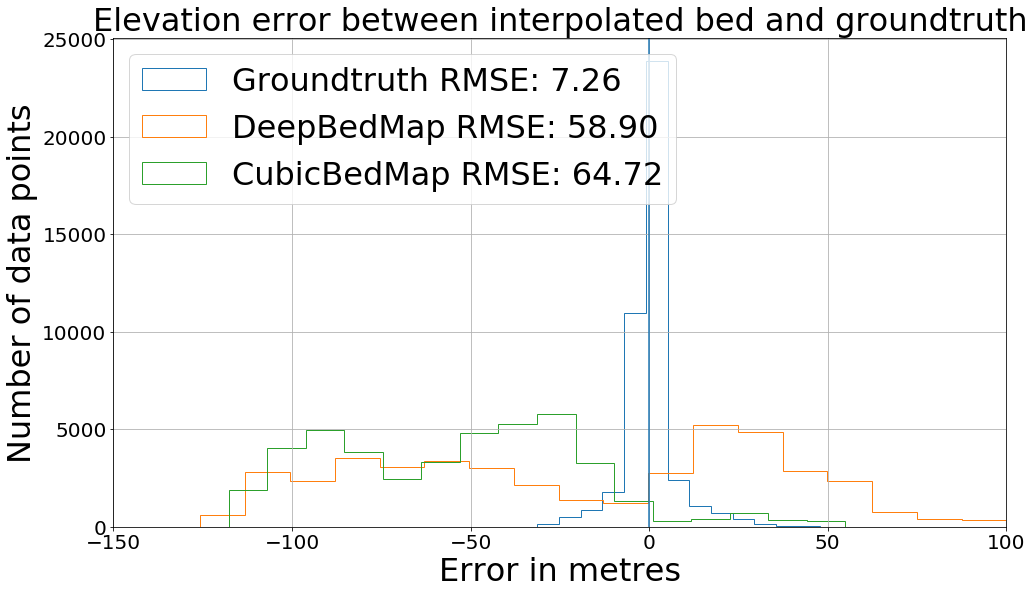

In [25]:
# https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4
rmse_groundtruth = (df_groundtruth.error ** 2).mean() ** 0.5
rmse_deepbedmap3 = (df_deepbedmap3.error ** 2).mean() ** 0.5
rmse_cubicbedmap = (df_cubicbedmap.error ** 2).mean() ** 0.5
rmse_synthetichr = (df_synthetichr.error ** 2).mean() ** 0.5

bins = 50

fig, ax = plt.subplots(figsize=(16, 9))
# ax.set_yscale(value="symlog")
ax.set_xlim(left=-150, right=100)
df_groundtruth.hist(
    column="error",
    bins=25,
    ax=ax,
    histtype="step",
    label=f"Groundtruth RMSE: {rmse_groundtruth:.2f}",
)
df_deepbedmap3.hist(
    column="error",
    bins=25,
    ax=ax,
    histtype="step",
    label=f"DeepBedMap RMSE: {rmse_deepbedmap3:.2f}",
)
df_cubicbedmap.hist(
    column="error",
    bins=25,
    ax=ax,
    histtype="step",
    label=f"CubicBedMap RMSE: {rmse_cubicbedmap:.2f}",
)
"""
df_synthetichr.hist(
    column="error",
    bins=bins,
    ax=ax,
    histtype="step",
    label=f"SyntheticHR RMSE: {rmse_synthetichr:.2f}",
)
"""

ax.set_title("Elevation error between interpolated bed and groundtruth", fontsize=32)
ax.set_xlabel("Error in metres", fontsize=32)
ax.set_ylabel("Number of data points", fontsize=32)
ax.legend(loc="upper left", fontsize=32)
plt.tick_params(axis="both", labelsize=20)
plt.axvline(x=0)

# plt.savefig(fname="elevation_error_histogram.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [26]:
print(f"Groundtruth RMSE: {rmse_groundtruth}")
print(f"DeepBedMap3 RMSE: {rmse_deepbedmap3}")
print(f"SyntheticHR RMSE: {rmse_synthetichr}")
print(f"CubicBedMap RMSE: {rmse_cubicbedmap}")
print(f"Difference      : {rmse_deepbedmap3 - rmse_cubicbedmap}")

Groundtruth RMSE: 7.257149356568182
DeepBedMap3 RMSE: 58.89923625301813
SyntheticHR RMSE: 158.77687548167867
CubicBedMap RMSE: 64.72484084941911
Difference      : -5.825604596400979


# 4. Antarctic-wide **DeepBedMap**

Using our neural network to predict the bed elevation of the whole Antarctic continent!
A previous version (April 2019) presented at EGU2019 can be found in this [issue](https://github.com/weiji14/deepbedmap/issues/133) with reproducible code in this [pull request](https://github.com/weiji14/deepbedmap/pull/136).

In [ ]:
# Bounding Box region in EPSG:3031 covering Antarctica
window_bound_big = rasterio.coords.BoundingBox(
    left=-2_700_000.0, bottom=-2_200_000.0, right=2_800_000.0, top=2_300_000.0
)
print(window_bound_big)

In [ ]:
X_tile, W1_tile, W2_tile, W3_tile = get_deepbedmap_model_inputs(
    window_bound=window_bound_big
)

In [ ]:
# Oh we will definitely need a GPU for this
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
model.to_gpu()

In [ ]:
# special zero padding for REMA, 5 pixels on top and bottom, 10 pixels on left and right
W1_tile = np.pad(
    array=W1_tile, pad_width=[(0, 0), (0, 0), (5, 5), (10, 10)], mode="constant"
)

In [ ]:
# the gapfilled Ice Velocity layer still has gaps (filled with -3.4027863e+38), so we clip to above 0.0
W2_tile = np.clip(a=W2_tile, a_min=0.0, a_max=None)

In [ ]:
print(X_tile.shape, W1_tile.shape, W2_tile.shape, W3_tile.shape)

## 4.1 The whole of Antarctica tiler and predictor!!

Antarctica won't fit into our 16GB of GPU memory, so we have to:

1. Cut a 250kmx250km tile and load the data within this one small tile into GPU memory
2. Use our GPU-enabled model to make a prediction for this tile area
3. Repeat (1) and (2) for every tile we have covering Antarctica

In [ ]:
# The whole of Antarctica tile and predictor
if 1 == 1:
    # Size are in kilometres
    final_shape = (18000, 22000)  # 4x that of BEDMAP2
    ary_height, ary_width = (1000, 1000)
    stride_height, stride_width = (1000, 1000)

    Y_hat = np.full(
        shape=(1, final_shape[0] + 20, final_shape[1] + 20),
        fill_value=np.nan,
        dtype=np.float32,
    )

    for y_step in range(0, final_shape[0], stride_height):
        for x_step in range(0, final_shape[1], stride_width):
            # plus 1 pixel on left and right
            x0, x1 = ((x_step // 4), ((x_step + ary_width) // 4) + 2)
            # plus 1 pixel on bottom and top
            y0, y1 = ((y_step // 4), ((y_step + ary_height) // 4) + 2)
            # x0, y0, x1, y1 = (3000,3000,3250,3250)

            X_tile_crop = cupy.asarray(a=X_tile[:, :, y0:y1, x0:x1], dtype="float32")
            W1_tile_crop = cupy.asarray(
                a=W1_tile[:, :, y0 * 10 : y1 * 10, x0 * 10 : x1 * 10], dtype="float32"
            )
            W2_tile_crop = cupy.asarray(
                a=W2_tile[:, :, y0 * 2 : y1 * 2, x0 * 2 : x1 * 2], dtype="float32"
            )
            W3_tile_crop = cupy.asarray(a=W3_tile[:, :, y0:y1, x0:x1], dtype="float32")

            Y_pred = model.forward(
                x=X_tile_crop, w1=W1_tile_crop, w2=W2_tile_crop, w3=W3_tile_crop
            )
            try:
                Y_hat[
                    :, (y0 * 4) + 4 : (y1 * 4) - 4, (x0 * 4) + 4 : (x1 * 4) - 4
                ] = cupy.asnumpy(Y_pred.array[0, :, :, :])
                # print(x0, y0, x1, y1)
            except ValueError:
                raise
            finally:
                X_tile_crop = W1_tile_crop = W2_tile_crop = W3_tile_crop = None

    Y_hat = Y_hat[:, 10:-10, 10:-10]

## 4.2 Save full map to file

In [ ]:
# Save BEDMAP3 to GeoTiff and NetCDF format
# Using int16 instead of float32 to keep things smaller
_ = save_array_to_grid(
    window_bound=window_bound_big,
    array=np.expand_dims(Y_hat.astype(dtype=np.int16), axis=0),
    outfilepath="model/deepbedmap3_big_int16",
    dtype=np.int16,
)

## 4.3 Show *the* DeepBedMap

In [ ]:
with rasterio.open("model/deepbedmap3_big_int16.tif") as raster_tiff:
    deepbedmap_dem = raster_tiff.read(indexes=1, masked=True)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, squeeze=True, figsize=(12, 12))
rasterio.plot.show(
    source=np.ma.masked_less(x=deepbedmap_dem, value=-3000, copy=False),
    transform=raster_tiff.transform,
    cmap="Blues_r",
    ax=ax,
)